<a href="https://colab.research.google.com/github/yukitiec/Research/blob/main/TPU_SpatterPrediction_0417.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
print("Device:",tpu.master())

Device: grpc://10.119.214.66:8470


In [ ]:
import numpy as np
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense,SimpleRNN, LSTM,Dropout,Convolution2D,MaxPooling2D
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import glob 
import os 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


(64, 64)
260
69


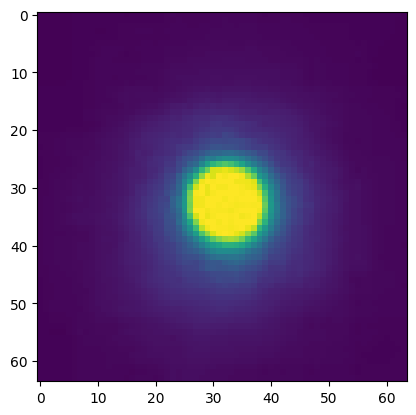

In [ ]:
## ///////// loading the data as DataFrame ////////////
#20220401
#file=pd.read_csv(filepath_or_buffer="/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/NN/dataset/train_dataset_2.csv")
#file_test = pd.read_csv(filepath_or_buffer= "/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/NN/dataset/test_dataset.csv")

#20220603
file_train = pd.read_csv(filepath_or_buffer = '/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/動画/20220603/train.csv')
value_train = file_train.values
file_test = pd.read_csv(filepath_or_buffer = '/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/動画/20220603/test.csv')
value_test = file_test.values

## ////////// テスト用とトレーニング用でデータをシャッフルする //////////////
import random #random.shuffle() : shuffle the data of 1D
from sklearn.utils import shuffle #for 2D shuffle

value_train = shuffle(value_train,random_state=42)#random_state = integer ; fix randomness with shuffling
value_test = shuffle(value_test,random_state=42)
#print(value_train.shape)

#value_test = shuffle(value_test, random_state =42)
#print(value_test.shape)

## //////////// Show example /////////
import cv2
import matplotlib.pyplot as plt

img=cv2.imread(value_train[100,1])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(gray.shape)
plt.imshow(gray)

## ////// making the dataset for train and test //////////

data_train = value_train[:,1:]
label_train =  value_train[:,0]


data_test = value_test[:,1:]
label_test = value_test[:,0]

def spatter(data):
  count = 0
  for i in range(len(data)):
    if data[i] == 1:
      count += 1
  print(count)

spatter(label_train)
spatter(label_test)


In [ ]:
def url2image(data):
  image_data = np.zeros((len(data),len(data[1]),64,64))
  for i in range(len(data)-1):
    for j,name in enumerate(data[i]):
      print((len(data),i,j))
      print(name)
      img=cv2.imread(name)
      #print(img)
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      image_data[i][j]=gray
  return image_data

In [ ]:
image_train = url2image(data_train)
image_test = url2image(data_test)

Streaming output truncated to the last 5000 lines.
(680, 557, 0)
/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/動画/20220603/video/xiQ_20220603_3-2/process/1046.jpg
(680, 557, 1)
/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/動画/20220603/video/xiQ_20220603_3-2/process/1045.jpg
(680, 557, 2)
/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/動画/20220603/video/xiQ_20220603_3-2/process/1044.jpg
(680, 557, 3)
/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/動画/20220603/video/xiQ_20220603_3-2/process/1043.jpg
(680, 557, 4)
/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/動画/20220603/video/xiQ_20220603_3-2/process/1042.jpg
(680, 557, 5)
/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/動画/20220603/video/xiQ_20220603_3-2/process/1041.jpg
(680, 557, 6)
/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/動画/20220603/video/xiQ_20220603_3-2/process/1040.jpg
(680, 557, 7)
/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/動画/20220603/video/xiQ_20220603_3-2/process/1039.jpg
(680, 557, 8)
/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/動画/20220603

In [ ]:
## split data into training data and test data 
image_train = image_train.reshape(len(image_train),10,64,64,1)
image_test = image_test.reshape(len(image_test),10,64,64,1)

#when calculating (dividing process) the type have to be float
image_train = image_train.astype("float32")
image_test = image_test.astype("float32")

#when training, it is convenient if the values are normalized
image_train= image_train/255
image_test = image_test/255

# converting data to float32, especially float32
image_train =np.asarray(image_train).astype(np.float32)
label_train = np.asarray(label_train).astype(np.int32)
image_test =np.asarray(image_test).astype(np.float32)
label_test = np.asarray(label_test).astype(np.int32)

print("length of label test : ",len(label_test))

#label_train_tensorflow=keras.utils.to_categorical(label_train)  #keras.utils.to_categorical : can see how the result of the judge is like [0.4,0.6] : no-spatter: 40%, spatter : 60%
#label_test_tensorflow=keras.utils.to_categorical(label_test)
#print(image_train)
print(image_train.shape)
print(type(label_train))

length of label test :  129
(680, 10, 64, 64, 1)
<class 'numpy.ndarray'>


In [ ]:
# convert label into array(2) [no-spatter, spatter]
def label_vec(label,dim):
  count=0
  lab = np.zeros((len(label),dim))  
  for i in range(len(label)):
    if label[i] == 1: #spatter
      lab[i,1] = 1
      count+=1
    else: #no spatter
      lab[i,0] = 1
  print('spatter label:{}'.format(count))
  return lab

lab_train = label_vec(label_train, 2)
lab_test = label_vec(label_test,2)

print("lab_train.shape ; " , lab_train.shape)
print("lab_test.shape : " , lab_test.shape)

spatter label:260
spatter label:69
lab_train.shape ;  (680, 2)
lab_test.shape :  (129, 2)


In [ ]:
##making CNN network : Training  Revised : 2022/08/29

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D,AveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import LayerNormalization
from sklearn.metrics import classification_report
from keras.layers import LSTM
from keras.utils import plot_model

#Normal Convolutional Layer

In [ ]:
from keras.engine.sequential import model_serialization
from tensorflow_datasets.core.dataset_builder import units
from tensorflow import keras
from keras import Input, Model
from keras.layers import TimeDistributed, Activation,BatchNormalization,SeparableConv2D,GRU
from keras import layers
from keras import backend as K
from keras.layers.core import Reshape

save_dir = '/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/NN/model/TPU_0424_5.{epoch:03d}-{val_loss:.2f}.hdf5'
Modelcheckpoint = keras.callbacks.ModelCheckpoint(filepath = save_dir, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

def conv_block(x,num_features,pooling=False):
  conv2d_1 = Conv2D(num_features,(3,3),padding = "same")
  outputs = TimeDistributed(conv2d_1)(x)
  #normalize_1 = BatchNormalization()
  #ouputs = TimeDistributed(normalize_1)(outputs)
  filter_0 = Activation('relu')
  outputs = TimeDistributed(filter_0)(outputs)

  #conv2d_2 = SeparableConv2D(num_features,(3,3),padding = "same")
  #outputs = TimeDistributed(conv2d_2)(outputs)
  #normalize_2 = BatchNormalization()
  #ouputs = TimeDistributed(normalize_2)(outputs)
  #filter_1 = Activation('relu')
  #outputs = TimeDistributed(filter_1)(outputs)

  pool_0 = MaxPooling2D((2,2),strides = 2,padding='same')#32*32
  outputs = TimeDistributed(pool_0)(outputs)

  return outputs

def build_model(input_size):
  inputs = Input(shape=input_size)
  outputs = conv_block(inputs,2,pooling=True) #80
  outputs = conv_block(outputs,4,pooling=True) #40
  outputs = conv_block(outputs,8,pooling=True) #20
  #outputs = conv_block(outputs,16,pooling=True) #10
  #outputs = conv_block(outputs,8,pooling=True) #5
  #outputs = conv_block(outputs,8,pooling=True) #3
  #outputs = conv_block(outputs,256,pooling=True) #1

  print(outputs.shape)
  """
  #Dense version
  outputs = Flatten()(outputs)#9*32
  x = Dense(80)(outputs)
  #x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x =Dropout(0.3)(x)

  x = Dense(80)(outputs)
  #x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.2)(x)

  x = Dense(80)(outputs)
  #x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.1)(x)

  x = Dense(80)(outputs)
  #x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.1)(x)

  x = Dense(80,activation='relu')(x)
  x = Dropout(0.1)(x)
  """


  x = TimeDistributed(Flatten())(outputs)

  x = LSTM(64,recurrent_dropout =0.3)(x)#,return_sequences=True)(x)
  #x = LSTM(300,recurrent_dropout =0.25)(x)
  #x = GRU(100,recurrent_dropout = 0.25)(x)
  x = Dropout(0.3)(x)


  output = Dense(2,activation='softmax')(x)
  model = Model(inputs = inputs,outputs = output)


  # Compiling the CNN
  opt = keras.optimizers.RMSprop()#Adam()
  model.compile(optimizer = opt, 
                    loss="binary_crossentropy",
                    metrics = ['accuracy']) 
  return model

#ResNet

In [ ]:
from logging import Filter
from keras.engine.sequential import model_serialization
from tensorflow_datasets.core.dataset_builder import units
from tensorflow import keras
from keras import Input, Model
from keras.layers import TimeDistributed, Activation,BatchNormalization,SeparableConv2D,GRU,Conv2D,GlobalAveragePooling2D,GlobalMaxPooling2D,LayerNormalization
from keras import layers
from keras import backend as K
from keras.layers.core import Reshape

save_dir = '/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/NN/model/TPU_0424_15.{epoch:03d}-{val_loss:.2f}.hdf5'
Modelcheckpoint = keras.callbacks.ModelCheckpoint(filepath = save_dir, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

def res_conv_block(x,num_features,pooling=False):
  residual = x
  conv2d_1 = Conv2D(num_features,(3,3),padding = "same")
  outputs = TimeDistributed(conv2d_1)(x)
  #normalize_1 = BatchNormalization()

  #ouputs = TimeDistributed(normalize_1)(outputs)
  filter_0 = Activation('relu')
  outputs = TimeDistributed(filter_0)(outputs)

  
  
  conv2d_2 = Conv2D(num_features,(3,3),padding = "same")
  outputs = TimeDistributed(conv2d_2)(outputs)
  #normalize_2 = BatchNormalization()
  #ouputs = TimeDistributed(normalize_2)(outputs)
  filter_1 = Activation('relu')
  outputs = TimeDistributed(filter_1)(outputs)

  if pooling:#whether Maxpooling layer is or not
    pool_0 = MaxPooling2D((2,2),strides = 2,padding='same')#32*32
    outputs = TimeDistributed(pool_0)(outputs)
    conv_res = Conv2D(num_features,1,strides = 2)
    residual = TimeDistributed(conv_res)(residual)
  else:
    conv_res = Conv2D(num_features,1)
    residual = TimeDistributed(conv_res)(residual)

  outputs = layers.add([outputs,residual])

  return outputs

def build_model(input_size):
  inputs = Input(shape=input_size)
  outputs = res_conv_block(inputs,2,pooling=True) #32
  #normalize_1 = LayerNormalization()
  #ouputs = TimeDistributed(normalize_1)(outputs)
  outputs = res_conv_block(outputs,4,pooling=False) #16
  #normalize_2 = LayerNormalization()
  #ouputs = TimeDistributed(normalize_2)(outputs)
  #outputs = res_conv_block(outputs,8,pooling=False) #8
  #normalize_3 = LayerNormalization()
  #ouputs = TimeDistributed(normalize_3)(outputs)
  #outputs = res_conv_block(outputs,16,pooling=True) #4
  #normalize_4 = LayerNormalization()
  #ouputs = TimeDistributed(normalize_4)(outputs)
  #outputs = res_conv_block(outputs,64,pooling=True) #4
  #outputs = res_conv_block(outputs,64,pooling=False) #4
  #normalize_4 = LayerNormalization()
  #ouputs = TimeDistributed(normalize_4)(outputs)
  filter = Activation('relu')
  outputs = TimeDistributed(filter)(outputs)
  pool = GlobalMaxPooling2D()
  outputs = TimeDistributed(pool)(outputs)
  #outputs = res_conv_block(outputs,64,pooling=True) #3
  #outputs = res_conv_block(outputs,256,pooling=True) #1

  print(outputs.shape)
  
  #Dense version
  
  outputs = Flatten()(outputs)#9*32
  x = Dense(16)(outputs)
  #x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x =Dropout(0.1)(x)

  x = Dense(16)(outputs)
  #x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.1)(x)

  x = Dense(16)(outputs)
  #x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.1)(x)
  

  """
  x = Dense(64)(outputs)
  #x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.1)(x)

  x = Dense(64,activation='relu')(x)
  x = Dropout(0.1)(x)
  """
  """
  x = TimeDistributed(Flatten())(outputs)

  #x = LSTM(100,recurrent_dropout =0.25,return_sequences=True)(x)
  #x = LSTM(64,recurrent_dropout =0.2,return_sequences = True)(x)
  x = LSTM(48,recurrent_dropout =0.25)(x)
  #x  = LSTM(64,recurrent_dropout =0.1)(x)
  #x = GRU(100,recurrent_dropout = 0.25)(x)
  x = Dropout(0.15)(x)
  """
  output = Dense(2,activation='softmax')(x)
  model = Model(inputs = inputs,outputs = output)


  # Compiling the CNN
  opt = keras.optimizers.RMSprop(learning_rate = 0.1)#Adam()
  model.compile(optimizer = opt, 
                    loss="binary_crossentropy",
                    metrics = ['accuracy']) 
  return model

In [ ]:
import tensorflow as tf
strategy = tf.distribute.TPUStrategy(tpu)
print("Number of replicas: {strategy.num_replicas_in_sync}")

with strategy.scope():
  model = build_model(input_size = (10,64,64,1))

Number of replicas: {strategy.num_replicas_in_sync}
(None, 10, 4)


In [ ]:
import tensorflow as tf 
def scheduler(epoch, lr=1e-3):
  if (epoch+1)%20 == 0:
    lr = lr*0.1
  return lr


callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

Epoch 1/80
 9/11 [=======================>......] - ETA: 0s - loss: 0.6675 - accuracy: 0.6128
Epoch 1: val_loss improved from inf to 0.73765, saving model to /content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/NN/model/TPU_0424_15.001-0.74.hdf5
11/11 [==============================] - 1s 138ms/step - loss: 0.6652 - accuracy: 0.6176 - val_loss: 0.7376 - val_accuracy: 0.4651 - lr: 1.0000e-05
Epoch 2/80
10/11 [==========================>...] - ETA: 0s - loss: 0.6639 - accuracy: 0.6203
Epoch 2: val_loss did not improve from 0.73765
11/11 [==============================] - 1s 96ms/step - loss: 0.6652 - accuracy: 0.6176 - val_loss: 0.7376 - val_accuracy: 0.4651 - lr: 1.0000e-05
Epoch 3/80
10/11 [==========================>...] - ETA: 0s - loss: 0.6654 - accuracy: 0.6172
Epoch 3: val_loss did not improve from 0.73765
11/11 [==============================] - 1s 97ms/step - loss: 0.6652 - accuracy: 0.6176 - val_loss: 0.7376 - val_accuracy: 0.4651 - lr: 1.0000e-05
Epoch 4/80
10/11 [=====================

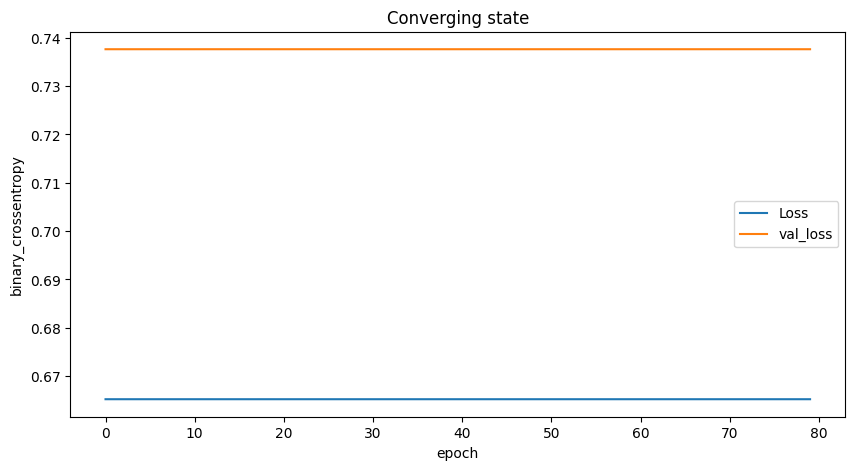

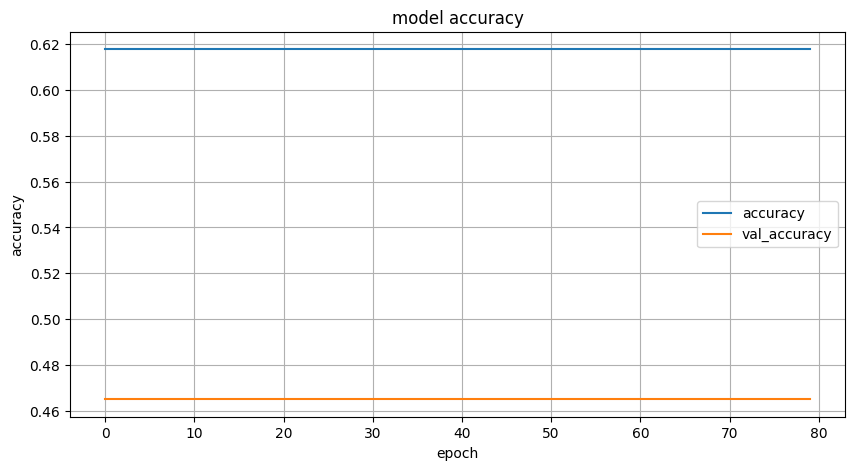

In [ ]:
import tensorflow as tf
import time

#model chechpoint

NUM_EPOCHS = 80
Batch = 64
t1  = time.time()
history = model.fit(image_train, lab_train, epochs=NUM_EPOCHS,validation_data = (image_test,lab_test), batch_size =Batch
                    ,callbacks = [callback,Modelcheckpoint]) 
t2 = time.time()

t = t2-t1
print("batch-size:{},learning time : {:.1f} [sec]".format(Batch,t))

#plot vonverging process : 
plt.subplots(figsize = (10,5))
plt.plot(history.history["loss"],label = "Loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.title("Converging state")
plt.xlabel("epoch")
plt.ylabel("binary_crossentropy")
plt.legend()
plt.show()

# Accuracy
plt.subplots(figsize = (10,5))
plt.plot(history.history['accuracy'], label = "accuracy")
plt.plot(history.history['val_accuracy'],label = 'val_accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')  # Y軸ラベル
plt.xlabel('epoch')  # X軸ラベル
plt.grid()
plt.legend(loc='best')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score,precision_score,recall_score

threshold = 0.5

#split label data into a scaler
def vec2scaler(data):
  spatter_label = []
  non_label = []
  for i in range(data.shape[0]):
    if data[i][0] == 1: #non spatter
      non_label.append(1)
      spatter_label.append(None)
    else:#spatter
      non_label.append(None)
      spatter_label.append(1)
  return spatter_label,non_label

def show_outputs(data,label_data):

  predict_data = model.predict(data)
  predict_0 = predict_data[:,0]
  predict_1 = predict_data[:,1]
  #threshold data
  result = np.zeros((predict_data.shape[0],predict_data.shape[1]))
  for i in range(predict_data.shape[0]):
    judge = np.argmax(predict_data[i,:])
    if judge == 0:
      result[i,0] = 1
    else:
      result[i,1] = 1


  spatter_label,non_label = vec2scaler(label_data)
  spatter_predict,non_predict = vec2scaler(result)

  #evaluation parameter
  TP = 0
  TN = 0
  FP = 0
  FN = 0

  for i in range(len(spatter_label)):

    if spatter_label[i] == 1:
      if spatter_predict[i] == 1:#TP
        TP +=1
      elif non_predict[i] == 1: #FN
        FN +=1
    elif non_label[i] == 1:
      if spatter_predict[i] == 1:#FP
        FP += 1
      elif non_predict[i] == 1:#TN
        TN += 1

  print("(TP,FN,FP,TN)",(TP,FN,FP,TN))

  all = len(spatter_label)
  print(all)
  accuracy = (TP+TN)/all
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  f_value = 2*precision*recall/(precision+recall)


  #plot non-spatter data
  fig,ax = plt.subplots(2,1, figsize=(40,20), tight_layout=True, facecolor="whitesmoke")
  #plt.subplot()
  ax[0].plot(predict_0, "r",linestyle = 'None',marker = 'o',label ='predict data')
  ax[0].plot(non_label, "b",linestyle = 'None', marker = 'o', label = 'raw data')
  ax[0].set_title('Non spatter')
  ax[0].axhline(y = threshold)
  ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
  #plt.show()

  #plt.subplot(2,1,2)
  #plt.subplot(figsize = (20,10))
  ax[1].plot(predict_1, "r",linestyle = 'None',marker = 'o',label ='predict data')
  ax[1].plot(spatter_label, "b",linestyle = 'None', marker = 'o', label = 'raw data')
  ax[1].set_title('Spatter')
  ax[1].axhline(y = threshold)
  ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
  plt.show()
  print("accuracy : " ,accuracy)
  print("precision:",precision)
  print("recall:",recall)
  print("f value:",f_value)

print('///////train data//////////////')
#show_outputs(image_train,lab_train)
print('//////////test data////////////')
show_outputs(image_test,lab_test)

///////train data//////////////
//////////test data////////////
5/5 [==============================] - 5s 929ms/step
(TP,FN,FP,TN) (0, 69, 0, 60)
129


ZeroDivisionError: ignored

#Evaluation

#Plot the transition of metrics with Threshold

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score,precision_score,recall_score

threshold = 0.5

#split label data into a scaler
def vec2scaler(data):
  spatter_label = []
  non_label = []
  for i in range(data.shape[0]):
    if data[i][0] == 1: #non spatter
      non_label.append(1)
      spatter_label.append(None)
    else:#spatter
      non_label.append(None)
      spatter_label.append(1)
  return spatter_label,non_label

def metrics_change(predict_data,label_data,threshold):
  Spatter = []

  #decide spatter or not according to threshold
  for i in range(predict_data.shape[0]):
    if predict_data[i,1] >= threshold:
      Spatter.append(1)
    else :
      Spatter.append(0)

  spatter_label,non_label = vec2scaler(label_data)

  #evaluation parameter
  TP = 0
  TN = 0
  FP = 0
  FN = 0

  for i in range(len(spatter_label)):

    if spatter_label[i] == 1:
      if Spatter[i] == 1:#TP
        TP +=1
      elif Spatter[i] == 0: #FN
        FN +=1
    elif non_label[i] == 1:
      if Spatter[i] == 1:#FP
        FP += 1
      elif Spatter[i] == 1:#TN
        TN += 1

  print("(TP,FN,FP,TN)",(TP,FN,FP,TN))

  all = len(spatter_label)
  print(all)
  accuracy = (TP+TN)/all
  if TP+FP > 0:
    precision = TP/(TP+FP)
  else:
    precision = None
  recall = TP/(TP+FN)
  if precision == 0 or precision == None or recall == 0:
    f_value = None
  else:
    f_value = 2/(1/precision+1/recall)
  
  return accuracy, precision, recall,f_value

5/5 [==============================] - 1s 16ms/step
(TP,FN,FP,TN) (69, 0, 60, 0)
129
(TP,FN,FP,TN) (69, 0, 60, 0)
129
(TP,FN,FP,TN) (69, 0, 60, 0)
129
(TP,FN,FP,TN) (69, 0, 60, 0)
129
(TP,FN,FP,TN) (69, 0, 60, 0)
129
(TP,FN,FP,TN) (69, 0, 60, 0)
129
(TP,FN,FP,TN) (0, 69, 0, 0)
129
(TP,FN,FP,TN) (0, 69, 0, 0)
129
(TP,FN,FP,TN) (0, 69, 0, 0)
129
(TP,FN,FP,TN) (0, 69, 0, 0)
129
(TP,FN,FP,TN) (0, 69, 0, 0)
129
(TP,FN,FP,TN) (0, 69, 0, 0)
129
(TP,FN,FP,TN) (0, 69, 0, 0)
129
(TP,FN,FP,TN) (0, 69, 0, 0)
129
(TP,FN,FP,TN) (0, 69, 0, 0)
129
(TP,FN,FP,TN) (0, 69, 0, 0)
129
(TP,FN,FP,TN) (0, 69, 0, 0)
129
(TP,FN,FP,TN) (0, 69, 0, 0)
129
(TP,FN,FP,TN) (0, 69, 0, 0)
129
(TP,FN,FP,TN) (0, 69, 0, 0)
129


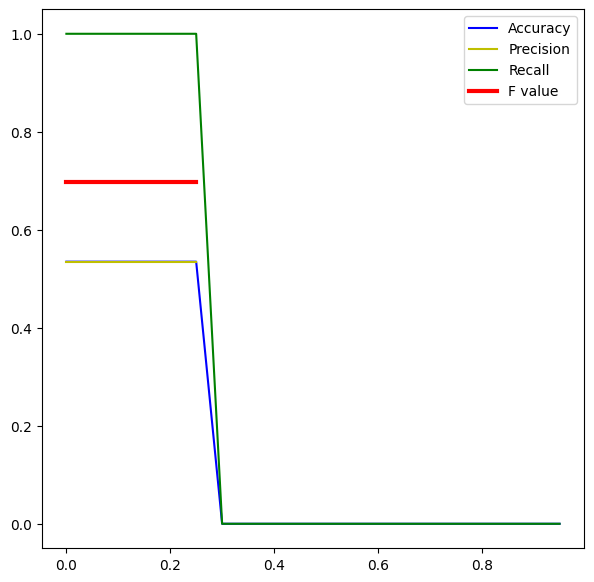

In [ ]:
import matplotlib.pyplot as plt

def frange(start, end , step):
    if step == 0:
        raise ValueError('step must not be zero')

    start = float(start)
    end = float(end)
    step = float(step)

    # range関数と同様な振る舞いにする
    if abs(step) > abs(start - end):
        return [start]
    if step > 0 and end - start < 0:
        return []
    elif step < 0 and end - start > 0:
        return []

    exp = len(str(step).split('.')[1])  # 丸める際に使用する桁数
    result = [start]
    val = start
    if step > 0:
        while (val := round(val + step, exp)) < end:
            result.append(val)
    else:
        while (val := round(val + step, exp)) > end:
            result.append(val)
    return result

Accuracy = []
Precision = []
Recall = []
F_value = []
Threshold = []

predict_data = model.predict(image_test)
for threshold in frange(0.0,1.0,0.05):
  accuracy,precision,recall,f_value = metrics_change(predict_data,lab_test,threshold)
  Threshold.append(threshold)
  Accuracy.append(accuracy)
  Precision.append(precision)
  Recall.append(recall)
  F_value.append(f_value)

plt.subplots(figsize=(7,7))
plt.plot(Threshold,Accuracy,color ='b',label = 'Accuracy')
plt.plot(Threshold,Precision,color ='y',label = 'Precision')
plt.plot(Threshold,Recall,color ='g',label = 'Recall')
plt.plot(Threshold,F_value,linewidth = 3,color ='r',label = 'F value')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

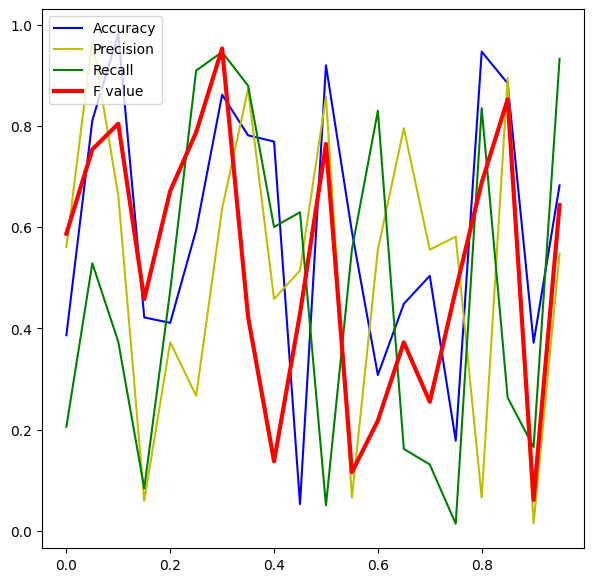

In [ ]:
import matplotlib.pyplot as plt
import random

def frange(start, end , step):
    if step == 0:
        raise ValueError('step must not be zero')

    start = float(start)
    end = float(end)
    step = float(step)

    # range関数と同様な振る舞いにする
    if abs(step) > abs(start - end):
        return [start]
    if step > 0 and end - start < 0:
        return []
    elif step < 0 and end - start > 0:
        return []

    exp = len(str(step).split('.')[1])  # 丸める際に使用する桁数
    result = [start]
    val = start
    if step > 0:
        while (val := round(val + step, exp)) < end:
            result.append(val)
    else:
        while (val := round(val + step, exp)) > end:
            result.append(val)
    return result

Accuracy = []
Precision = []
Recall = []
F_value = []
Threshold = []
for threshold in frange(0.0,1.0,0.05):
  Threshold.append(threshold)
  Accuracy.append(random.random())
  Precision.append(random.random())
  Recall.append(random.random())
  F_value.append(random.random())


plt.subplots(figsize=(7,7))
plt.plot(Threshold,Accuracy,color ='b',label = 'Accuracy')
plt.plot(Threshold,Precision,color ='y',label = 'Precision')
plt.plot(Threshold,Recall,color ='g',label = 'Recall')
plt.plot(Threshold,F_value,linewidth = 3,color ='r',label = 'F value')
plt.legend()
plt.show

#model structure

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 10, 64, 64,  0           []                               
                                 1)]                                                              
                                                                                                  
 time_distributed_89 (TimeDistr  (None, 10, 64, 64,   80         ['input_7[0][0]']                
 ibuted)                        8)                                                                
                                                                                                  
 time_distributed_90 (TimeDistr  (None, 10, 64, 64,   0          ['time_distributed_89[0][0]']    
 ibuted)                        8)                                                          

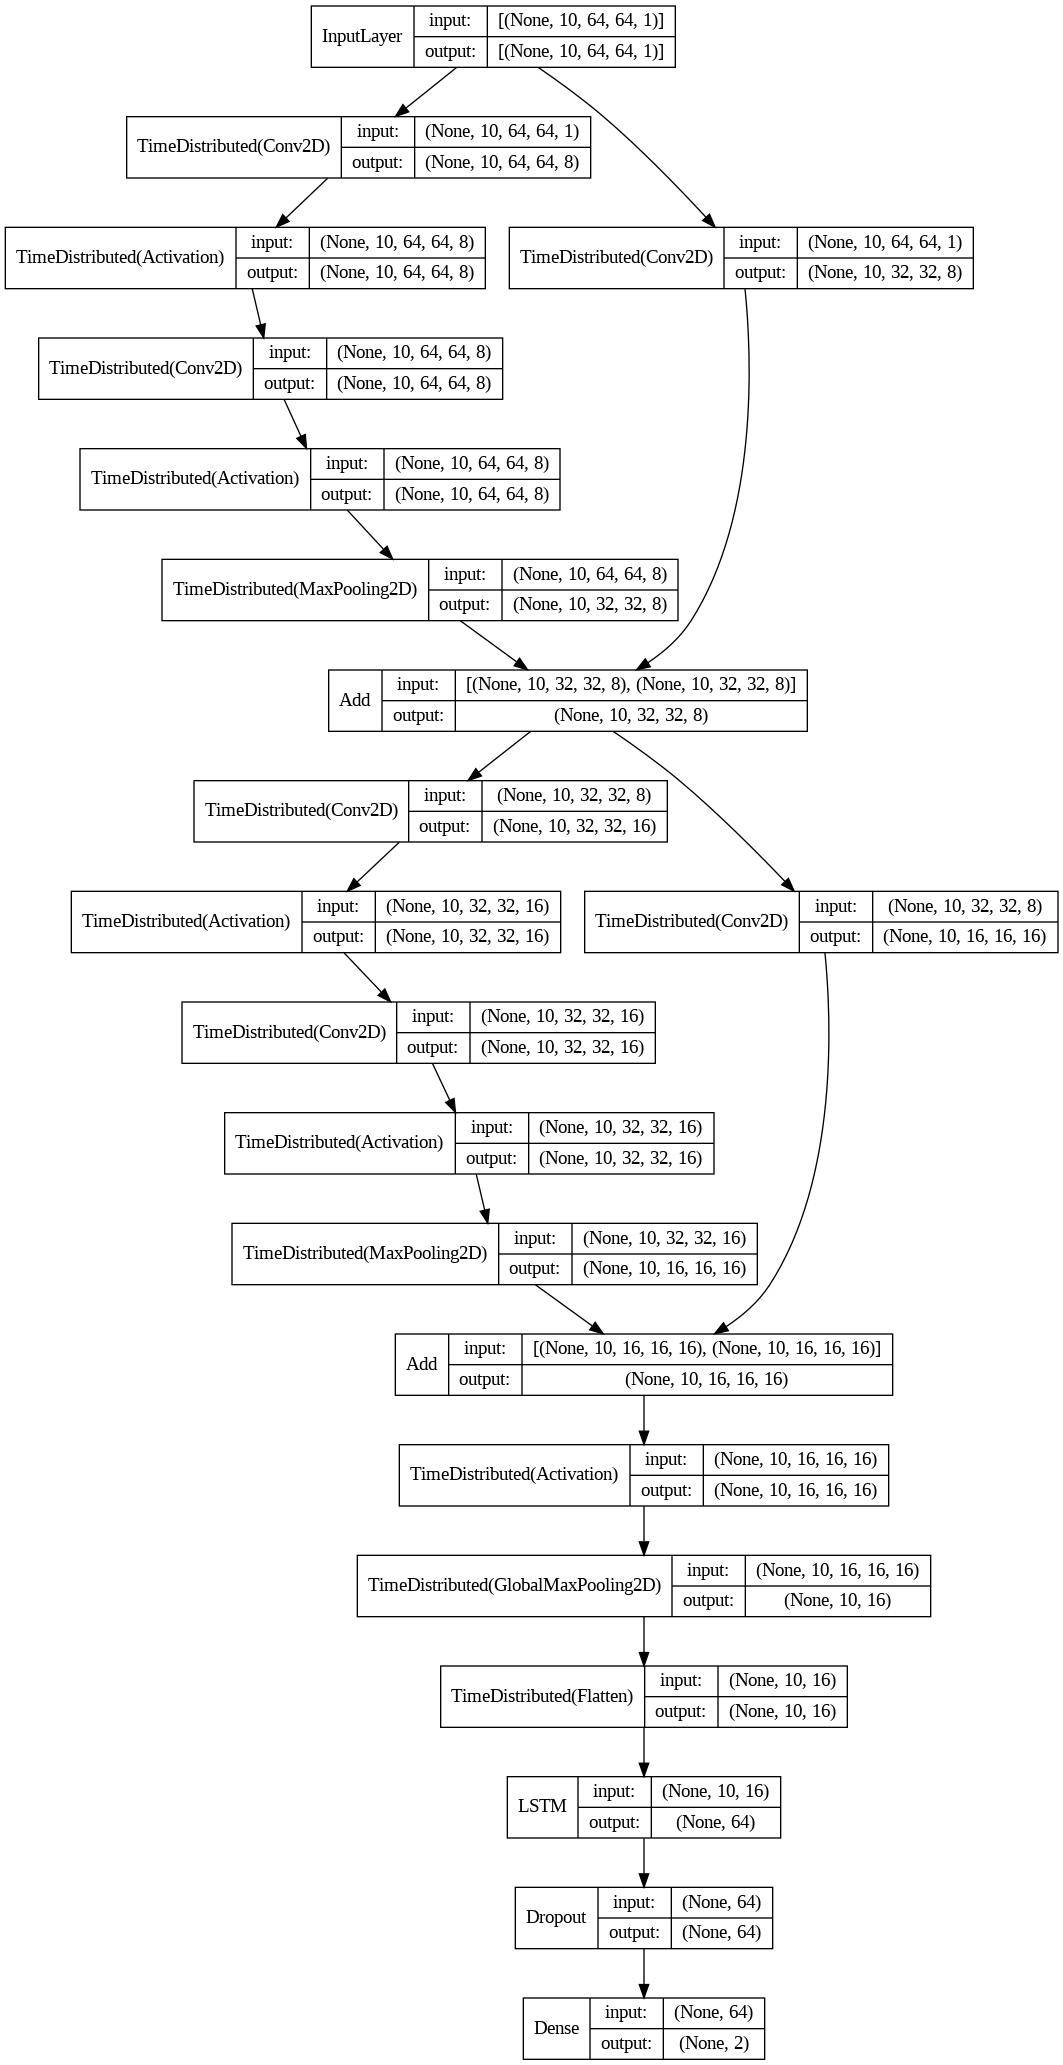

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes = True,show_layer_names = False)

#make heatmap

define model

In [ ]:
last_conv_layer_name = 'time_distributed_101' 
classifier_layer_names = ['time_distributed_102','time_distributed_103','lstm_6','dropout_6','dense_6']
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs,last_conv_layer.output)

adapt classifer for last conv layer

In [ ]:
classifier_input = keras.Input(shape = last_conv_layer.output.shape[1:])
x = classifier_input
#make model
for layer_name in classifier_layer_names:
  x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input,x)

get gradients of highly predicted class

In [ ]:
import tensorflow as tf

img = image_train[2]
img = np.expand_dims(img,axis=0)
with tf.GradientTape() as tape:

  #calculate last conv layer's activation and enroll for GradientTape
  last_conv_layer_output = last_conv_layer_model(img) #(1,9,7.7,32)
  print(last_conv_layer_output.shape)
  tape.watch(last_conv_layer_output)

  #get a channel of most highly predicted class
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  top_class_channel = preds[:,top_pred_index] #tensor shape=(1,)

#last class gradient based on last conv layer as input
grads = tape.gradient(top_class_channel,last_conv_layer_output) #(1,9,7,7,32)

(1, 10, 16, 16, 16)


weighting each channel

In [ ]:
Heatmap = np.zeros((last_conv_layer_output.shape[1],last_conv_layer_output.shape[2],last_conv_layer_output.shape[3]))
for i in range(grads.shape[1]):
  grads_tmp = grads[0,i,:,:,:]
  #averaging for each filter
  pooled_grads = tf.reduce_mean(grads_tmp,axis=(0,1)).numpy()
  print(pooled_grads.shape)#(1,9)
  last_conv_layer_output_tmp = last_conv_layer_output.numpy()[0][i]
  print(last_conv_layer_output_tmp.shape)#

  #multiply weights by each filter
  for j in range(pooled_grads.shape[-1]):
    last_conv_layer_output_tmp[:,:,j] *= pooled_grads[j]

  #average for each filter
  heatmap = np.mean(last_conv_layer_output_tmp,axis = -1) #all
  print(heatmap.shape)
  Heatmap[i,:,:] = heatmap

(16,)
(16, 16, 16)
(16, 16)
(16,)
(16, 16, 16)
(16, 16)
(16,)
(16, 16, 16)
(16, 16)
(16,)
(16, 16, 16)
(16, 16)
(16,)
(16, 16, 16)
(16, 16)
(16,)
(16, 16, 16)
(16, 16)
(16,)
(16, 16, 16)
(16, 16)
(16,)
(16, 16, 16)
(16, 16)
(16,)
(16, 16, 16)
(16, 16)
(16,)
(16, 16, 16)
(16, 16)


normalization of heatmap for 0~1

<ipython-input-51-59a037147277>:3: RuntimeWarning: invalid value encountered in divide
  Heatmap[i,:,:] = Heatmap[i,:,:]/np.max(Heatmap[i,:,:])


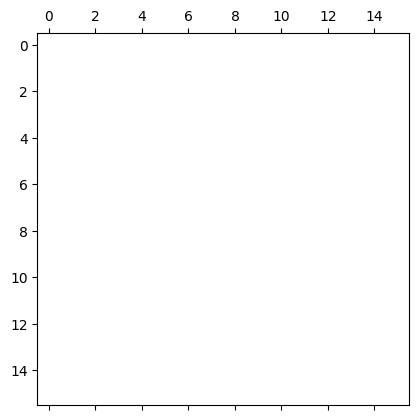

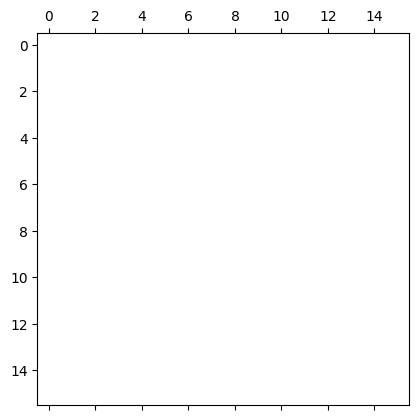

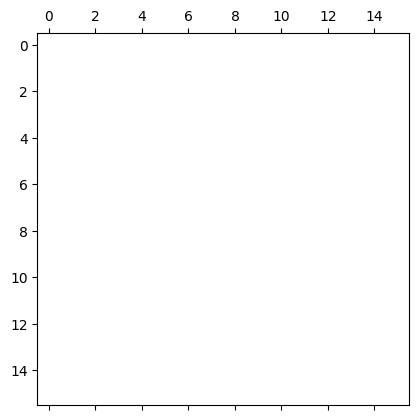

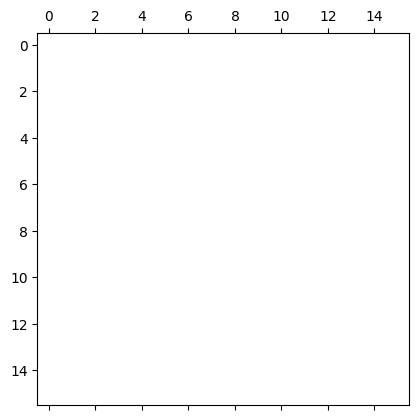

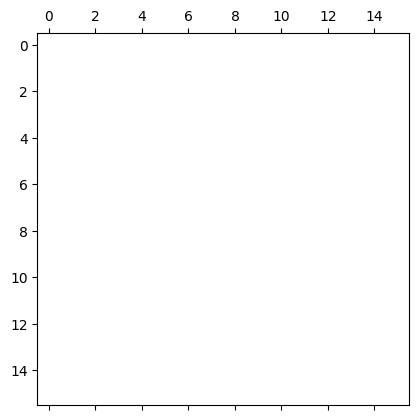

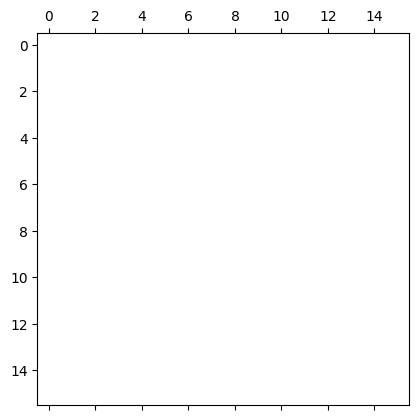

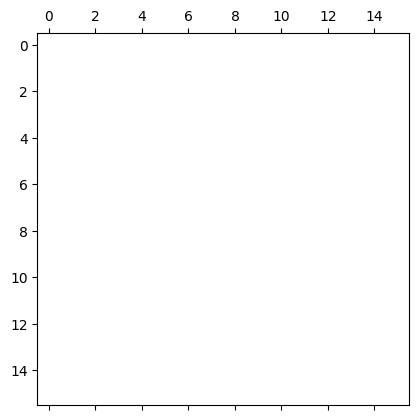

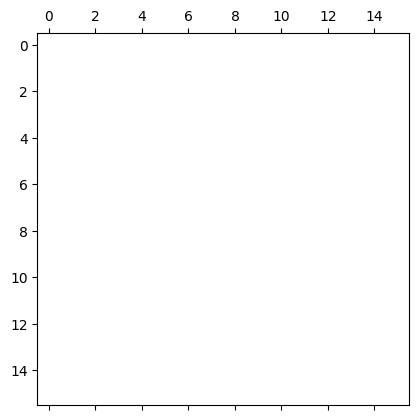

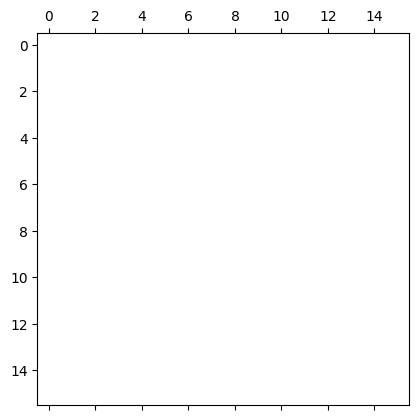

In [ ]:
for i in range(9):
  Heatmap[i,:,:] = np.maximum(Heatmap[i,:,:],0)
  Heatmap[i,:,:] = Heatmap[i,:,:]/np.max(Heatmap[i,:,:])
  plt.matshow(Heatmap[i,:,:])

superimpose heatmap to original image

<ipython-input-52-772bd1de0353>:9: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255*heatmap)
<ipython-input-52-772bd1de0353>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')


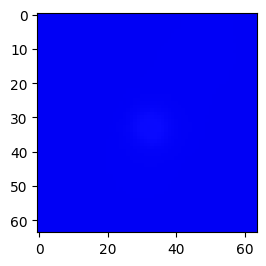

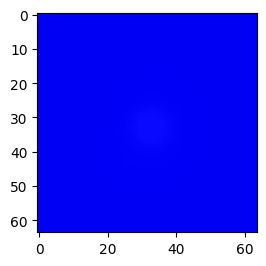

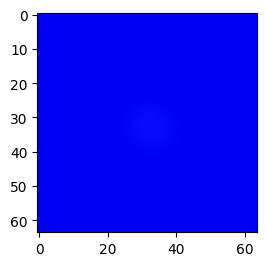

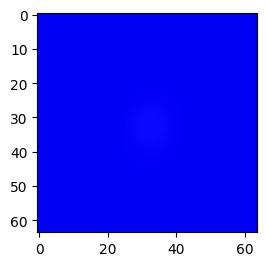

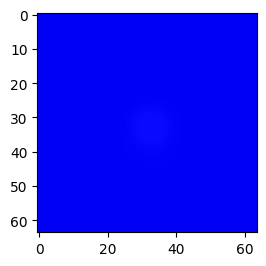

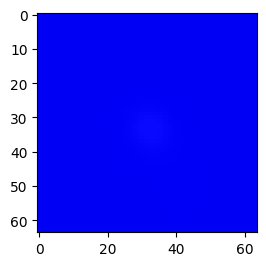

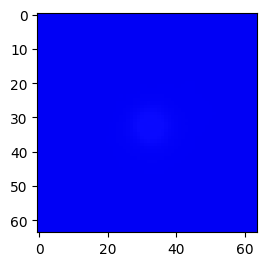

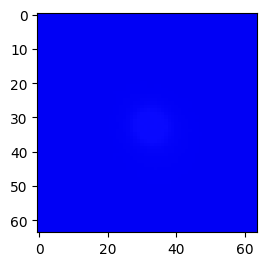

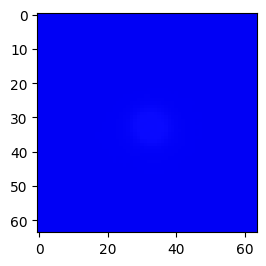

In [ ]:
import matplotlib.cm as cm
from google.colab.patches import cv2_imshow

for i in range(9):
  img = image_train[2][i]
  img = keras.utils.img_to_array(img)
  
  heatmap = Heatmap[i,:,:]
  heatmap = np.uint8(255*heatmap)
  #coloring heatmap
  jet = cm.get_cmap('jet')
  jet_colors = jet(np.arange(256))[:,:3]
  jet_heatmap = jet_colors[heatmap]

  #make img with heatmap
  jet_heatmap = keras.utils.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1],img.shape[0])) #order is different betweendimage and array
  jet_heatmap = keras.utils.img_to_array(jet_heatmap)

  #transparency rate = 40%
  superimposed_img = jet_heatmap*0.1+img
  superimposed_img = keras.utils.array_to_img(superimposed_img)
  plt.figure(figsize=(30,3))
  plt.subplot(1,9,i+1)
  plt.imshow(superimposed_img)
  #save_path="/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/%02d.jpg"%(i+1)
  #superimposed_img.save(save_path)



#HyperParameter Tuning

In [ ]:
!pip install keras-tuner -q

In [ ]:
from tensorflow import keras
from keras.engine.sequential import model_serialization
from tensorflow_datasets.core.dataset_builder import units
from tensorflow import keras
from keras import Input, Model
from keras.layers import TimeDistributed, Activation,BatchNormalization,SeparableConv2D,Flatten,LSTM,Dropout,Dense,MaxPooling2D
from keras import layers
from keras import backend as K
from keras.layers.core import Reshape
from tensorflow.keras import layers


def conv_block(x,num_features,pooling=False):
  residual = x
  conv2d_1 = SeparableConv2D(num_features,(3,3),padding = "same")
  outputs = TimeDistributed(conv2d_1)(x)
  #normalize_1 = BatchNormalization()
  #ouputs = TimeDistributed(normalize_1)(outputs)
  filter_0 = Activation('relu')
  outputs = TimeDistributed(filter_0)(outputs)

  conv2d_2 = SeparableConv2D(num_features,(3,3),padding = "same")
  outputs = TimeDistributed(conv2d_2)(outputs)
  #normalize_2 = BatchNormalization()
  #ouputs = TimeDistributed(normalize_2)(outputs)
  filter_1 = Activation('relu')
  outputs = TimeDistributed(filter_1)(outputs)

  pool_0 = MaxPooling2D((2,2),strides = 2,padding='same')#32*32
  outputs = TimeDistributed(pool_0)(outputs)

  if pooling:#whether Maxpooling layer is or not
    conv_res = SeparableConv2D(num_features,1,strides = 2)
    residual = TimeDistributed(conv_res)(residual)
  else:
    conv_res = SeparableConv2D(num_features,1)
    residual = TimeDistributed(conv_res)(residual)

  outputs = layers.add([outputs,residual])

  return outputs

#hyperparameter space
def build_model(hp):
  #Search arean for hyperparameter exploration
  #////////////////
  units1 = hp.Int(name='units',min_value=4,max_value=8,step=4)
  units2 = hp.Int(name='units',min_value=4,max_value=16,step=4)
  units3 = hp.Int(name='units',min_value=8,max_value=32,step=8)
  units4 = hp.Int(name='units',min_value=8,max_value=64,step=8)
  units5 = hp.Int(name='units',min_value=16,max_value=128,step=16)
  #////////////////

  #model structure
  inputs = Input(shape=(10,160,160,1))
  outputs = conv_block(inputs,units1,pooling=True) #80
  outputs = conv_block(outputs,units2,pooling=True) #40
  outputs = conv_block(outputs,units3,pooling=True) #20
  outputs = conv_block(outputs,units4,pooling=True) #10
  outputs = conv_block(outputs,units5,pooling=True) #5*5
  #outputs = conv_block(outputs,64,pooling=True) #2*2
  x = TimeDistributed(Flatten())(outputs)
  x = LSTM(100,recurrent_dropout =0.25)(x)
  x = Dropout(0.1)(x)
  output = Dense(2,activation='softmax')(x)
  model = Model(inputs = inputs,outputs = output)  
  ###########

  #optimizer selection
  optimizer = hp.Choice(name='optimizer',values = ["rmsprop","adam"])
  model.compile(optimizer = optimizer,
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy'])
  
  return model


#HyperParameter Tuning

In [ ]:
import os
 
tpu_cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver("grpc://%s" % os.environ["COLAB_TPU_ADDR"])
 
tf.config.experimental_connect_to_cluster(tpu_cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(tpu_cluster_resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.experimental.TPUStrategy(tpu_cluster_resolver)

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
#tuner : (1)RandomSearch, (2) BaysianOptimization, (3) Hperhand

import keras_tuner as kt

strategy = tf.distribute.TPUStrategy(tpu)
print("Number of replicas: {strategy.num_replicas_in_sync}")

tuner = kt.BayesianOptimization(
  #model constructing function
  build_model,
  #index for comparison
  objective = 'val_accuracy',
  #max num of trials
  max_trials = 30,
  #num of trial per one model -> adapt average score
  executions_per_trial = 2,

  #directory for search log
  directory = '/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/NN/SpatterPrediction',

  #TPU
  distribution_strategy = strategy,

  #whether overwritten: when model is changed, overwrite = True, when wanting to continue the previous one, overwrite = False,
  overwrite = True
  )


#show search area
tuner.search_space_summary

Number of replicas: {strategy.num_replicas_in_sync}


<bound method BaseTuner.search_space_summary of <keras_tuner.tuners.bayesian.BayesianOptimization object at 0x7faae829a850>>

In [ ]:
num_val = int(image_train.shape[0]*0.8)
print(num_val)

count_train = 0
count_val = 0

image_val = image_train[num_val:]
lab_val = lab_train[num_val:]

image_training = image_train[:num_val]
lab_training = lab_train[:num_val]

for i in range(num_val):
  if lab_train[i][1] == 1:
    count_train += 1
print("training data, spatter label:{}".format(count_train))

for i in range(lab_val.shape[0]):
  if lab_val[i][1] == 1:
    count_val += 1

print("validation data, spatter lable:{}".format(count_val))


2000
training data, spatter label:895
validation data, spatter lable:234


In [ ]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=7)]

tuner.search(image_training,lab_training,
            batch_size = 64,
            epochs = 60,
            validation_data = (image_val,lab_val),
            callbacks =[keras.callbacks.EarlyStopping(monitor='val_loss',patience=7)],
            verbose=2)

Trial 2 Complete [00h 01m 13s]

Best val_accuracy So Far: None
Total elapsed time: 00h 02m 45s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
8                 |?                 |units
adam              |?                 |optimizer

Epoch 1/60


32/32 - 51s - loss: 0.6898 - accuracy: 0.5465 - val_loss: 0.6909 - val_accuracy: 0.5320 - 51s/epoch - 2s/step
Epoch 2/60


Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/keras_tuner/engine/base_tuner.py", line 250, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras_tuner/engine/base_tuner.py", line 215, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras_tuner/engine/tuner.py", line 284, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras_tuner/engine/tuner.py", line 211, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras_tuner/engine/hypermodel.py", line 142, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.wi

RuntimeError: ignored

In [ ]:
tuner.result_summary(top_num = 5)

In [ ]:
import tensorflow as tf 
def scheduler(epoch, lr=1e-3):
  lr = lr*tf.math.exp(-(epoch/50))
  return lr


callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

Trial 1 Complete [00h 00m 50s]

Best val_accuracy So Far: None
Total elapsed time: 00h 00m 50s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
4                 |?                 |units
rmsprop           |?                 |optimizer



KeyboardInterrupt: ignored